# Overhead setting

In [166]:
# Initial imports
import os
import json
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import  datetime
from dateutil.relativedelta import relativedelta


In [4]:
# Load .env enviroment variables
load_dotenv()

True

In [ ]:
# Set Alpaca API key and secret key
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [167]:
# Universal variables:

end = datetime.date.today()
begin=end-pd.DateOffset(365*T)
st=begin.strftime('%Y-%m-%d')
ed=end.strftime('%Y-%m-%d')

T=6
selected_company="AMZN"
bench_mark="SPY"


In [183]:
# Functions

def n_year_ago(n):
    # to get the date of "n years ago from today"
    n_years_ago=(end-pd.DateOffset(365*n)).strftime('%Y-%m-%d')
    return n_years_ago



# Grab data from Alpaca API

In [169]:
# Format current date as ISO format
start_date = pd.Timestamp(st, tz="America/New_York").isoformat()
end_date = pd.Timestamp(ed, tz="America/New_York").isoformat()

# Set the tickers list to fetch info from Alpaca API

tickers = [selected_company, bench_mark]


# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices in tickers list
df_raw = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df


# Create function to generate metrics

* 1-year/5-year rolling return 
* annualized rolling volatility 
* annualized rolling sharpe ratio 
* 1-year/5-year cumulative return 


In [196]:
def risk_return_metrics(df,ticker,years_list):

    df_ticker=df[['close','symbol']].loc[df['symbol']==ticker].drop(columns='symbol')
    df_ticker['daily_return']=df_ticker['close'].pct_change()
    
    
    # calculate n-year rolling return and cum return
    for years in years_list:
        
        # calculate n-year rolling total return
        df_ticker[f'{years}yr_return']=df_ticker['close'].pct_change(periods=252*years)
        # calculate n-year rolling annualized return if n>1
        if years>1:
            df_ticker[f'{years}yr_return_annualzd']=(1+df_ticker[f'{years}yr_return'])**(1/years)-1
        # calculate n-year cum return
        df_ticker[f'{years}yr_cum_return'] = (1 + df_ticker['daily_return'])[n_year_ago(years):].cumprod() - 1  
    
    
    # calculate annualized rolling standard deviation:
    df_ticker['annualizd_volatility']=df_ticker['daily_return'].rolling(252).std()*(252**0.5)
    # calculate annualized rolling sharpe ratio:
    df_ticker['annualizd_sharpe']=(252**0.5)*(df_ticker['daily_return'].rolling(252).mean()/df_ticker['annualizd_volatility'])
    
    return df_ticker
    


,close,daily_return,1yr_return,1yr_cum_return,5yr_return,5yr_return_annualzd,5yr_cum_return,annualizd_volatility,annualizd_sharpe
timestamp,,,,,,,,,
2022-04-08 04:00:00+00:00,3089.21,-0.021067,-0.086424,-0.09093,2.452094,0.281199,2.491935,0.316845,-0.008112


<AxesSubplot:xlabel='timestamp'>

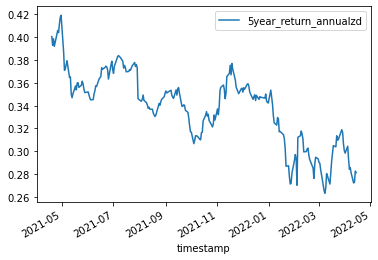

In [197]:
years_list=[1,5]
s_df=risk_return_metrics(df_raw,selected_company,years_list)

b_df=risk_return_metrics(df_raw,bench_mark,[1,5])
s_df.loc['2022-04-08']
s_df[['5year_return_annualzd']].plot()
